# Amazon Rekognition

Detectar caracteristicas e Humor de pessoas em imagens

# Reconhecimento de Faces

In [1]:
# Imports
from PIL import Image, ImageDraw, ImageFont
import sys
import boto3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [8]:
# Funções

def openLocalImage(imageFile):
    image = Image.open(imageFile)
    draw = ImageDraw.Draw(image);
    return [image,draw]

def saveImage(imageFile, imageInfo, prefix='reko_', format='PNG'):
    image = getImage(imageInfo)
    image.save(prefix+imageFile, format)

def getImage(imageInfo):
    return imageInfo[0]     # PIL.Image object

def getDraw(imageInfo):
    return imageInfo[1]     # PIL.Draw object

def drawLinesAroundFace(imageInfo, face, color='orange', width=5):
    image = getImage(imageInfo)
    draw = getDraw(imageInfo)
    lines = computeFaceCoordinates(image, face)
    draw.line(lines, fill=color, width=width)

def printFaceInformation(face, faceCounter):
    print('\n *** Rosto n° ' + str(faceCounter) + ' encontrado, confiança: ' +str(face['Confidence']))
    print('Sexo: '+ face['Gender']['Value'])
    print('Idade entre '+str(face['AgeRange']['Low'])+" e "+str(face['AgeRange']['High']))
    if (face['Beard']['Value']):
        print ('Barba')
    if (face['Mustache']['Value']):
        print ('Bigode')
    if (face['Eyeglasses']['Value']):
        print ('Oculos')
    if (face['Sunglasses']['Value']):
        print ('Oculos de Sol')
    for e in face['Emotions']:
        print(e['Type']+' '+str(e['Confidence']))

def printLabelsInformation(labels):
    for l in labels:
        print('Label ' + l['Name'] + ', Confiança: ' + str(l['Confidence']))

def drawLegendForFace(imageInfo, face, counter=0, font='arial.ttf', fontSize=24, fill=(255, 255, 255)):
    font = ImageFont.truetype(font, fontSize)
    image = getImage(imageInfo)
    draw = getDraw(imageInfo)
    faceCoordinates = computeFaceCoordinates(image, face)
    legendCoordinates = computeLegendCoordinates(faceCoordinates)
    legendText = buildLegendText(counter)
    draw.text(legendCoordinates, legendText, fill, font)

def drawLegendForCount(imageInfo, counter=0, font='arial.ttf', fontSize=24, fill=(255, 255, 1)):
    font = ImageFont.truetype(font, fontSize)
    image = getImage(imageInfo)
    draw = getDraw(imageInfo)
    draw.text((10,300), 'Rostos Encontrados: ' + str(counter), fill, font)
    
    
def computeFaceCoordinates(image, face):
    # Extract fractional values
    left   = face['BoundingBox']['Left']
    top    = face['BoundingBox']['Top']
    width  = face['BoundingBox']['Width']
    height = face['BoundingBox']['Height']
    # Convert fractional values to pixel values
    topLeftX        = (int)(image.width*left)
    topLeftY        = (int)(image.height*top)
    topRightX       = (int)(topLeftX + image.width*width)
    topRightY       = topLeftY
    bottomRightX    = topRightX
    bottomRightY    = (int)(topRightY + image.height*height)
    bottomLeftX     = topLeftX
    bottomLeftY     = bottomRightY
    return [topLeftX, topLeftY, topRightX, topRightY,
            bottomRightX, bottomRightY, bottomLeftX, bottomLeftY,
            topLeftX, topLeftY]

def computeLegendCoordinates(imageCoordinates):
    x = imageCoordinates[6]     # bottomLeftX
    y = imageCoordinates[7]+10  # bottomLeftY+10: write legend 10 pixels lower
    return (x,y)


def buildLegendText(counter, prefix='Rosto'):
    return prefix+str(counter)

def addRectangleAroundFace(imageInfo, face, fill=None, color='white'):
    rectangle = computeRectangleCoordinates(getImage(imageInfo), face)
    draw.rectangle(rectangle, fill, color)

def computeRectangleCoordinates(image, face):
    # Extract fractional values
    left   = face['BoundingBox']['Left']
    top    = face['BoundingBox']['Top']
    width  = face['BoundingBox']['Width']
    height = face['BoundingBox']['Height']
    # Convert fractional values to pixel values
    x0 = (int)(image.width*left)
    y0 = (int)(image.height*top)
    x1 = (int)(x0 + image.width*width)
    y1 = (int)(y0 + image.height*height)
    return [x0, y0, x1, y1]


defaultRegion = 'us-east-1'
defaultUrl = 'https://rekognition.eu-west-1.amazonaws.com'

def connectToRekognitionService(regionName=defaultRegion):
    return boto3.client('rekognition', region_name=regionName)

def detectFaces(rekognition, imageBucket, imageFilename, attributes='ALL'):
    resp = rekognition.detect_faces(
            Image = {"S3Object" : {'Bucket' : imageBucket, 'Name' : imageFilename}},
            Attributes=[attributes])
    return resp['FaceDetails']

def compareFaces(rekognition, imageBucket, imageSourceFilename, imageTargetFilename):
    resp = rekognition.compare_faces(
            SourceImage = {"S3Object" : {'Bucket' : imageBucket, 'Name' : imageSourceFilename}},
            TargetImage = {"S3Object" : {'Bucket' : imageBucket, 'Name' : imageTargetFilename}})
    return resp['FaceMatches']

def detectLabels(rekognition, imageBucket, imageFilename, maxLabels=100, minConfidence=0):
    resp = rekognition.detect_labels(
        Image = {"S3Object" : {'Bucket' : imageBucket, 'Name' : imageFilename}},
        MaxLabels = maxLabels, MinConfidence = minConfidence)
    return resp['Labels']


def copyLocalFileToS3(filename, bucketName):
    boto3.client('s3').upload_file(filename, bucketName, filename)

def exibeImagem(imageFile,imageInfo, prefix='reko_', format='.PNG'):
    image = getImage(imageInfo)
    plt.figure(figsize=(10,10))
    imgplot = plt.imshow(image)
    plt.show()

def reconhecerRostos(imageBucket, image):
    
    copyLocalFileToS3(image, imageBucket)

    imageInfo   = openLocalImage(image)
   
    reko = connectToRekognitionService()
   
    labels = detectLabels(reko, imageBucket, image, maxLabels=10, minConfidence=70.0)
    printLabelsInformation(labels)

    faceList = detectFaces(reko, imageBucket, image)
    faceCounter = 0
    for face in faceList:
        printFaceInformation(face, faceCounter)
        drawLinesAroundFace(imageInfo, face)
        drawLegendForFace(imageInfo, face, faceCounter)
        faceCounter=faceCounter+1
    
    drawLegendForCount(imageInfo, faceCounter)       
    saveImage(image, imageInfo)
    exibeImagem(image, imageInfo)
    
    if (faceCounter == 0):
        message = "Nenhum rosto foi encontrado :("
    else:
        if (faceCounter == 1):
            message = "Um unico rosto foi encontrado"
        else:
            message = str(faceCounter)+ " rostos foram encontrados"

    labelText = ''
    for l in labels:
        if (l['Confidence'] > 80.0):
            labelText = labelText + l['Name'] + ", "

Label Human, Confiança: 99.0542221069336
Label People, Confiança: 99.05421447753906
Label Person, Confiança: 99.0542221069336
Label Crowd, Confiança: 82.6313247680664

 *** Rosto n° 0 encontrado, confiança: 99.99404907226562
Sexo: Female
Idade entre 27 e 44
HAPPY 88.0578842163086
CALM 2.5083303451538086
SAD 1.7317235469818115

 *** Rosto n° 1 encontrado, confiança: 99.96592712402344
Sexo: Male
Idade entre 20 e 38
Oculos
DISGUSTED 38.44636535644531
SAD 17.00187873840332
CONFUSED 16.944683074951172

 *** Rosto n° 2 encontrado, confiança: 99.96284484863281
Sexo: Male
Idade entre 35 e 55
SAD 36.04937744140625
HAPPY 7.773008346557617
ANGRY 2.1244287490844727

 *** Rosto n° 3 encontrado, confiança: 99.7308120727539
Sexo: Male
Idade entre 26 e 44
HAPPY 65.72066497802734
SAD 2.739882469177246
ANGRY 1.774144172668457

 *** Rosto n° 4 encontrado, confiança: 96.21834564208984
Sexo: Male
Idade entre 17 e 27
Oculos
ANGRY 82.78751373291016
SURPRISED 19.042890548706055
SAD 1.4868736267089844

 *** Ro

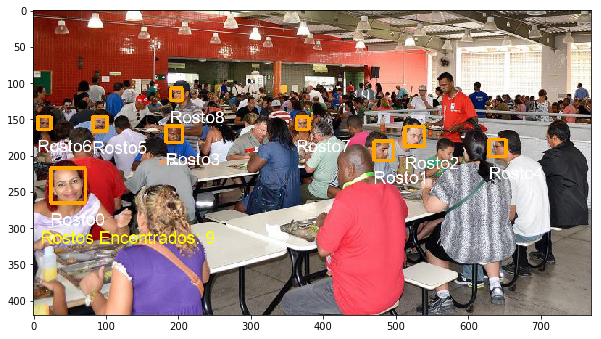

In [9]:
# Identificação de rostos

imageBucket = 'rekognition-blog'
image = 'image1.jpg'
    
reconhecerRostos(imageBucket, image)